In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [9]:
train_x.shape, _.shape, test_x.shape, _.shape

((60000, 28, 28), (10000,), (10000, 28, 28), (10000,))

### Fashion MNIST 또한 MNIST와 같이 28x28 픽셀의 이미지로,  
### 각 픽셀은 0~255 사이의 정숫값

In [10]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 이미지를 [-1, 1]로 정규화합니다.
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())
print(255 / 2)

max pixel: 255
min pixel: 0
max pixel: 1.0
min pixel: -1.0
127.5


 CNN(합성곱) 계층을 다룰 때 배웠듯, 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요합니다.  
 입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라지는데요,  
 __컬러 이미지의 경우 R, G, B 3 개의 channels  
 Gray Scale(흑백)의 경우 1개의 channel__  
 Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이기에   
 데이터셋의 shape 마지막에 1을 추가

In [11]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

In [21]:
train_x[0].shape, \
train_x[0].reshape(28, 28).shape

((28, 28, 1), (28, 28))

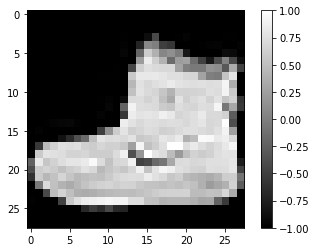

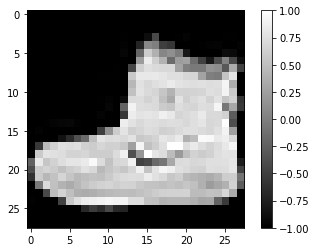

In [22]:
plt.imshow(train_x[0], cmap='gray')
plt.colorbar()
plt.show()

plt.figure()

plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
# plt.axis("off")
plt.show()

첫 번째, 즉 index 0의 이미지는 바로 신발이었군요.  
`plt.colorbar()` 를 이용해 오른쪽에 각 픽셀의 값과 그에 따른 색도 확인해 보았습니다.   
픽셀에는 우리가 정규화 해준 대로 -1 ~ 1 사이의 값을 가지고,  
-1이 가장 어두운 검은색,  
1이 가장 밝은 흰색을 띤다고 표시되어 있습니다.

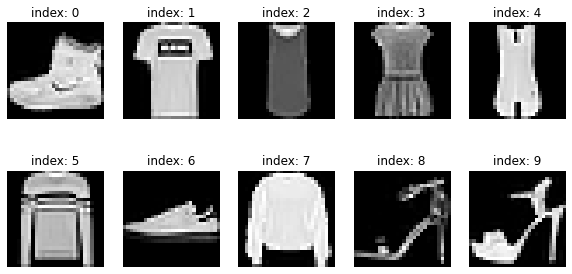

In [25]:
plt.figure(figsize=(10, 5)) # 전체 프레임의 크기를 결정

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

#### Q11. for 문을 활용해서 이미지 25개를 5x5 의 배열로 띄워보세요.  
단, 모든 이미지는 train_images에서 랜덤으로 추출해 보세요.  
(힌트 : numpy에서 랜덤으로 정수를 추출해 주는 함수를 찾아보세요!)

dir(np.random)
>>>
 'rand',
 'randint',
 'randn',
 'random',

In [30]:
np.random.rand(5, 5)
# Random values in a given shape.
# 0 ~ 1

array([[0.30876472, 0.26731056, 0.43048194, 0.1118966 , 0.99216696],
       [0.99484696, 0.25571723, 0.14318867, 0.01658296, 0.01857233],
       [0.17504909, 0.4633218 , 0.34203015, 0.71277849, 0.85500047],
       [0.12320773, 0.88425528, 0.41965176, 0.61349661, 0.25320876],
       [0.10817304, 0.47938952, 0.16612334, 0.00716638, 0.44854655]])

In [32]:
np.random.randn(3, 3)
# Return a sample (or samples) from the "standard normal" distribution.
# -1 ~ 1

array([[ 1.14324958,  0.76991735, -0.07310923],
       [-0.01662371,  0.94415292, -0.8629229 ],
       [-1.31403625,  0.04105202,  0.30264996]])

In [34]:
# random() takes at most 1 positional argument (2 given --> 5, 5)
np.random.random(5)
# Return random floats in the half-open interval [0.0, 1.0). 
# Alias for `random_sample` to ease forward-porting to the new random API.

array([0.05078825, 0.54116912, 0.6634667 , 0.31641458, 0.69786549])

In [35]:
np.random.randint(5)
#randint(low, high=None, size=None, dtype=int)
# Return random integers from `low` (inclusive) to `high` (exclusive).

3

In [49]:
print(np.random.randint(-5, 1))
print(np.random.randint(-5, 1))

0
-5


In [47]:
np.random.randint(0, 255, size=5)

array([147, 190, 195,  19, 114])

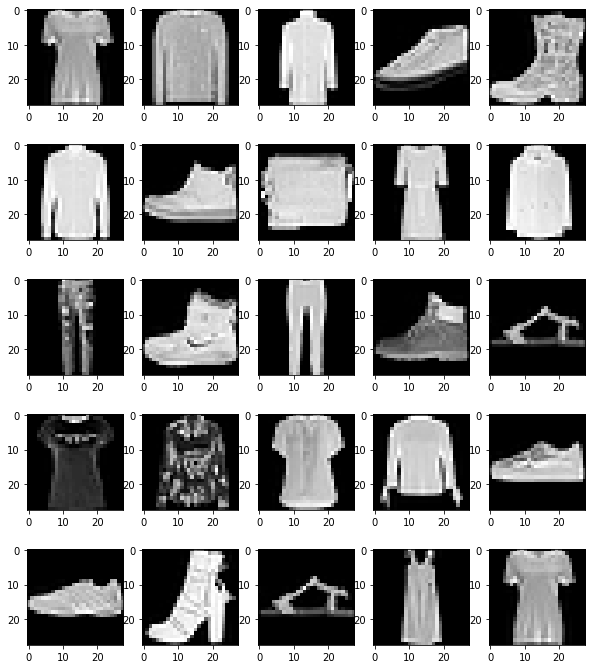

In [51]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i +1)
    plt.imshow(train_x[np.random.randint(0, 255)].reshape(28, 28), cmap='gray')

plt.show()

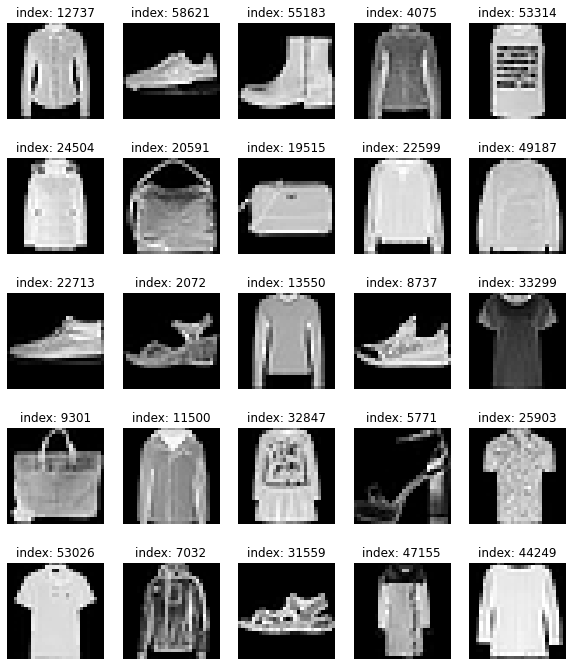

In [54]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i +1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

`BUFFER_SIZE`은 전체 데이터를 섞기 위해 60,000으로 설정합니다.  
`shuffle()`함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.  
`BATCH_SIZE`는 모델이 한 번에 학습할 데이터의 양입니다.  
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고,  
한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다.  
> 이러한 방식을 __미니 배치 학습__

In [55]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

`tf.data.Dataset.from_tensor_slices(tensors)`  
Creates a `Dataset` whose elements are slices of the given tensors.  

---
tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하면  
list, Numpy 또는 Tensorflow의 텐서 자료형에서 데이터셋을 만들 수 있습니다  

In [64]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_x라는 넘파이 배열(numpy ndarray)형 자료를 섞고,  
이를 batch size에 따라 나누도록 합니다.  
데이터가 잘 섞이게 하기 위해서는 buffer size를 total data size와 같거나 크게 설정하는 것이 좋습니다.

In [65]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

### Generator 생성자 구현하기
DCGAN(Deep Convolutional GAN)

In [73]:
def make_generator_model():
    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), 
                                     padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [74]:
generator = make_generator_model()

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)        

In [81]:
7 * 7 * 256
# 12544 * 100 = 1,254,400

12544

In [90]:
(819200 - 128) / 128

6399.0

In [99]:
256 * 5 * 5

6400

In [85]:
128 * 5 * 2 * 64 + 64

81984

In [100]:
(204800 - 64) / 64

3199.0

In [101]:
128 * 5 * 5

3200

In [103]:
(1600 -1) / 64

24.984375

In [104]:
5 * 5

25

[1, 28, 28, 1] 사이즈의 이미지가 잘 생성되    
첫 번째 1은 1개(batch_size=1)라는 뜻을,   
그 뒤로는 (28, 28, 1) 사이즈 이미지가 생성되었다

In [75]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-2.2820315 ,  0.20993553,  0.88725895,  0.47871673,  1.4802258 ,
         2.591783  ,  1.3151006 ,  0.0625482 , -1.340981  , -0.8012401 ,
         0.9433612 ,  0.3620305 ,  2.3645995 , -0.05331983,  0.1079281 ,
        -1.02994   ,  1.0308975 , -0.82602847,  0.30048522,  0.9721595 ,
        -0.4829013 , -0.78273   ,  1.2623295 , -1.7668579 , -0.6810413 ,
         0.66150343,  1.5085673 ,  0.6252941 , -0.228969  ,  0.4097403 ,
         0.29020488, -1.2472135 ,  0.4717743 ,  0.77759504,  2.3998933 ,
         0.25639582, -0.41770947, -1.9537991 , -0.30045316,  0.4386322 ,
        -0.9605313 ,  0.08443899, -0.4521708 ,  0.9282373 ,  1.7622827 ,
         0.02061102, -0.0262402 ,  0.6702639 ,  1.0080119 ,  1.2919452 ,
         0.12563427,  0.75691354, -0.12650123,  1.6571497 , -0.17570949,
         0.31832236, -0.27778548,  1.2265741 ,  1.2528597 ,  0.51044923,
         0.19448413,  0.21625727,  0.8983743 , -0.7755017 , -0.3111763 ,
 

단, 지금은 학습하는 중이 아니니 training=False를 설정해 주어야 합니다  
Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이  
다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수 있습니다

In [76]:
generated_image = generator(noise, training=False)
generated_image

<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
array([[[[-1.62362389e-03],
         [-1.04229874e-03],
         [ 2.72121048e-03],
         [ 1.79279142e-03],
         [ 3.39219463e-04],
         [-8.46536597e-04],
         [ 7.55241886e-03],
         [-9.34442331e-04],
         [-6.16886932e-03],
         [ 6.69407286e-03],
         [ 4.72879037e-03],
         [ 5.40282717e-03],
         [-4.77291550e-03],
         [-4.32745554e-03],
         [-1.76678807e-03],
         [ 1.62237827e-02],
         [ 5.34970488e-04],
         [ 2.03061220e-03],
         [ 7.52536021e-03],
         [ 6.75696740e-03],
         [-7.95321725e-03],
         [ 9.65418702e-04],
         [-7.33894529e-03],
         [ 5.39245550e-03],
         [-1.04010105e-05],
         [-5.78496186e-03],
         [ 1.06369518e-02],
         [ 5.55193005e-03]],

        [[-4.10573790e-03],
         [ 1.87398493e-03],
         [-3.72819323e-03],
         [ 5.50334994e-03],
         [-1.07358983e-02],
         [-9.10665

matplotlib 라이브러리는  
2차원 이미지만 보여줄 수 있으므로  
0번째와 3번째 축의 인덱스를 0으로 설정해서  
(28, 28) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

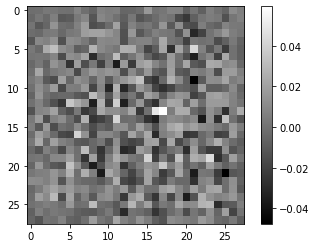

In [77]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

In [80]:
generated_image.shape

TensorShape([1, 28, 28, 1])

### Discriminatorm 판별자 설계
판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면  
각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 합니다.

In [70]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU()) ###
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU()) ###
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

입력은 (28, 28, 1) 크기의 이미지가,  
출력은 단 하나의 숫자(진짜라고 판단하는 정도)

In [71]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

`Conv2DTranspose` 층을 사용해서 이미지를 키워나갔던 생성자와 반대로,  
판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.  

첫 번째 Conv2D 층에서 입력된 [28, 28, 1] 사이즈의 이미지는  
다음 층을 거치며 (28, 28, 1) → (14, 14, 64) → (7, 7, 128)  

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272,  
즉 (1, 6272) 형상의 벡터로 변환합니다

### Generator
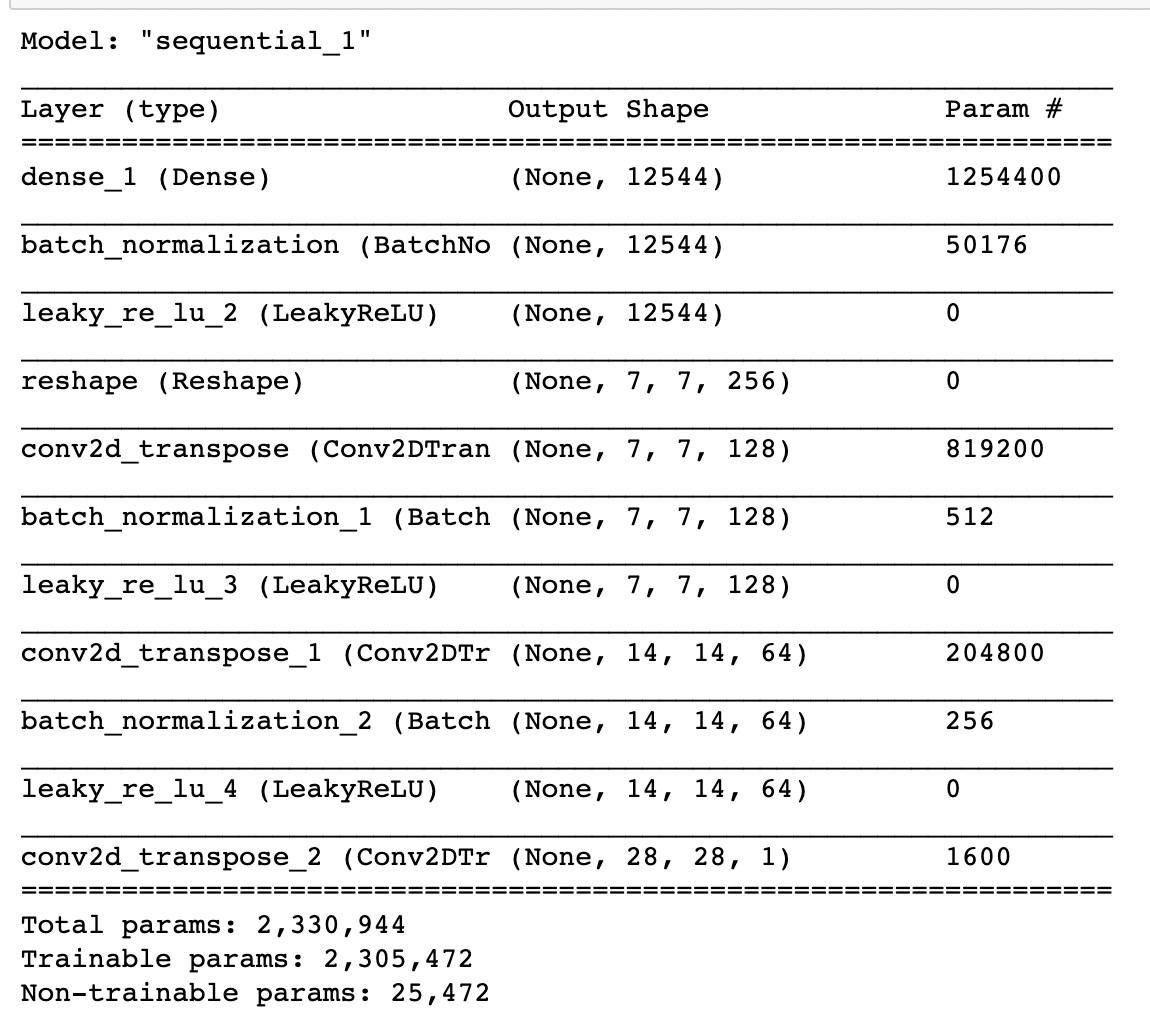
`Conv2DTranspose` 층을 이용해  
(7, 7, 256) → (14, 14, 64) → (28, 28, 1) 순으로 이미지를 키워나갑니다.  
`tanh`를 사용하는데, 이는 우리가  
-1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함

In [78]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00031439]], dtype=float32)>

In [109]:
discriminator??

지금은 학습하는 중이 아니니 training=False를 설정 -> Freeze -> pre-train 역할.  
Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르기 때문에 training=False을 주어야 올바른 결과를 얻을 수

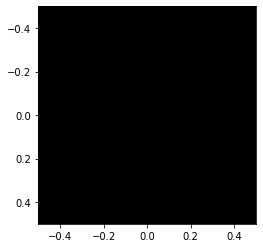

In [114]:
plt.imshow(decision, cmap='gray');

### (1) 손실함수와 최적화 함수

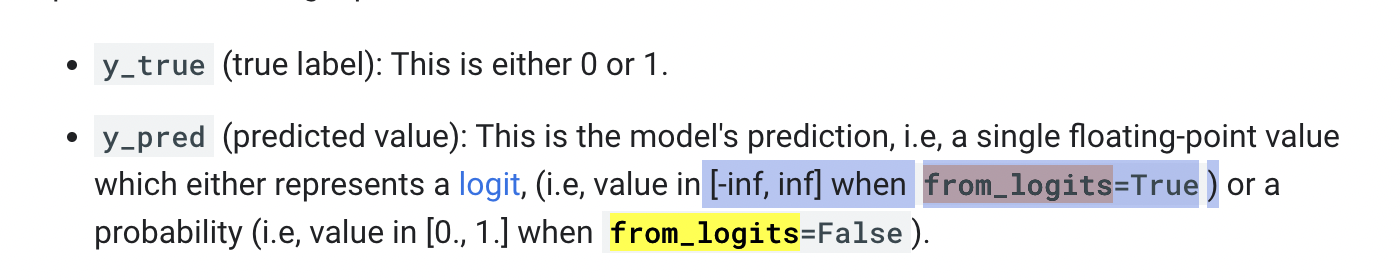

In [115]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

`fake_output, real_output = 1 , 0`
어떻게 비교할 수 있을까요?

바로 `tf.ones_like()`와 `tf.zeros_like()` 함수를 활용하면 됩니다.
이 함수들은 __특정 벡터와 동일한 크기__ 이면서 
__value은 1 또는 0__ 으로 가득 채워진 벡터를 만들고 싶을 때 사용합니다.

In [132]:
vector = [[1., 2., 3.],
          [4., 5., 6.]]

# tf.ones_like(vector)

In [138]:
cross_entropy(tf.zeros_like(vector), vector)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5860198>

In [127]:
vector = [[1., 2., 3.],
          [4., 5., 6.]]

# tf.zeros_like(vector)

In [128]:
cross_entropy(tf.ones_like(vector), vector)

<tf.Tensor: shape=(), dtype=float32, numpy=0.08601967>

`generator_loss`는  
fake_output가 1에 가까워지기를 바라므로,  
`tf.ones_like`와의 교차 엔트로피값을 계산

---
즉, `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은  
__fake_output__ 이 (Real Image를 의미하는) __1에 가까울수록 작은 값__ 을 가집니다

cross_entropy(y_true, y_pred, sample_weight=None)  
Type:           BinaryCrossentropy  
y_true -> 1의 값  
y_pred -> fake_output

In [120]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

real_output 값은 1에 가까워지기를,  
fake_output 값은 0에 가까워지기를 바라므로,  
두 가지 loss값을 모두 계산  
real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교

In [119]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가,  
서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.  
fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다

tf.math.greater_equal(x, y, name=None)  

Returns the truth value of (x >= y) element-wise.

---
tf.math.less(x, y, name=None)  

Returns the truth value of (x < y) element-wise.

In [123]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracyreal

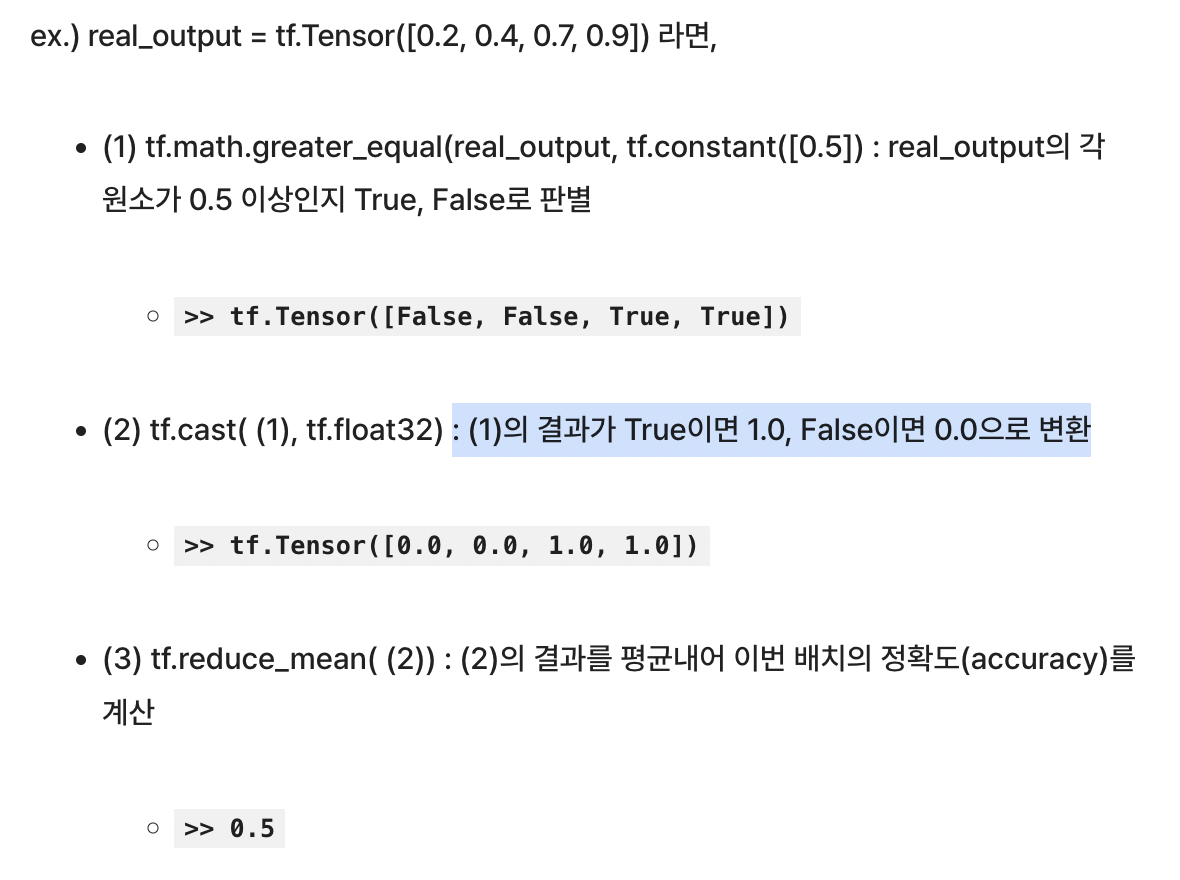

In [139]:
# learning rate"는 0.0001
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

`tf.random.normal`  
(
    shape,
    mean=0.0,
    stddev=1.0,
    dtype=tf.float32,
    seed=None,
    name=None,
)

Outputs random values from a normal distribution.

---
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록

In [140]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [141]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.08867207,  0.488152  ,  0.6134829 , ..., -0.38835967,
         2.275119  , -0.0853384 ],
       [-0.6206133 ,  0.06293832,  0.41124186, ..., -0.10409068,
        -0.15288028,  0.8239441 ],
       [ 0.96151817, -0.13596801, -0.14556064, ..., -0.7116602 ,
        -0.35071325, -0.81516784],
       ...,
       [ 3.7932818 ,  1.0996958 , -0.69095737, ..., -0.67537594,
         0.20247534,  1.0824461 ],
       [ 2.1949985 , -1.1596539 , -0.3894131 , ...,  0.22762619,
        -1.3672903 ,  0.13962616],
       [-0.23003617,  0.81359285,  1.3910735 , ...,  0.12586911,
         0.9556567 , -0.68641233]], dtype=float32)>

# 6-12. 생성 모델이 똑똑해지기 위한 기나긴 여정 (2) 훈련과정 설계
하나의 미니 배치 당 진행할 train_step 함수를 먼저 만들어야 합니다

In [167]:
import matplotlib as mama, gaga

ModuleNotFoundError: No module named 'gaga'

In [150]:
import matplotlib as mlp, matplotlib.pyplot as plt123

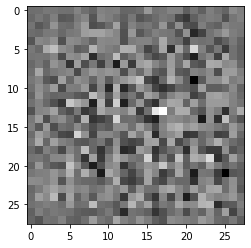

In [153]:
mlp.pyplot.imshow(generated_image[0, :, :, 0], cmap='gray')

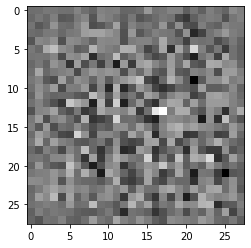

In [152]:
plt123.imshow(generated_image[0, :, :, 0], cmap='gray')

In [156]:
with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    print(1)

1


In [163]:
tf.GradientTape??
Init signature: tf.GradientTape(persistent=False, watch_accessed_variables=True)
Source:        
@tf_export("GradientTape", "autodiff.GradientTape", v1=["GradientTape"])
class GradientTape(object):

In [161]:
gen_tape??
Type:           GradientTape
String form:    <tensorflow.python.eager.backprop.GradientTape object at 0x7fbfb40101f0>
File:           /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/backprop.py

In [162]:
disc_tape??
Type:           GradientTape
String form:    <tensorflow.python.eager.backprop.GradientTape object at 0x7fbfb4075460>
File:           /opt/conda/lib/python3.9/site-packages/tensorflow/python/eager/backprop.py

In [142]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

1. __`normal`__ ization  
> 정규화 (-1) ~ 1의 값을 shape([BATCH_SIZE, noise_dim])로 

2. `tf.GradientTape`
> Record operations for automatic differentiation.
> Gradient를 자동 미분으로 계산

3. `generator(noise, training=True)` -> generated_images 생성
> generator = def make_generator_model() -> layer 쌓았다유
> noise = tf.random.normal([1, 100])

4. discriminator 판별 -> real_output, fake_output 출력
> images -> input data
> discriminator = def make_discriminator_model():

5. loss 계산
> gen_loss -> cross_entropy(tf.ones_like(fake_output), fake_output)
> disc_loss -> total_loss = real_loss + fake_loss

6. accuracy 계산
> tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])
> tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5]))
>> -> real_accuracy, fake_accuracy

7. gradient 계산
> tf.GradientTape().gradient

8. model 학습
> generator_optimizer = tf.keras.optimizers.Adam(1e-4).apply_gradients
변수에다가 기울기 값을 적용시킨다유....

generator.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(100, 12544) dtype=float32, numpy=
 array([[ 2.9698014e-05,  1.6227067e-02,  1.8054765e-02, ...,
         -2.9888786e-03,  1.6509470e-02,  1.9104328e-02],

discriminator.trainable_variables

[<tf.Variable 'conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32, numpy=
 array([[[[ 0.02717542,  0.0374014 ,  0.0336445 , ..., -0.00814586,
            0.04823178, -0.00459285]],

`tf.GradientTape.gradient`  
(
    self,
    target,
    sources,
    output_gradients=None,
    unconnected_gradients=<UnconnectedGradients.NONE: 'none'>,
)

Computes the gradient using operations recorded in context of this tape.

dir(tf.GradientTape)
'batch_jacobian',
 'gradient',
 'jacobian',
 'reset',
 'stop_recording',
 'watch',
 'watched_variables']

`tf.keras.optimizers.Adam.apply_gradients`  
(
    self,
    grads_and_vars,
    name=None,
    experimental_aggregate_gradients=True,
)

Apply gradients to variables.

이러한 일련의 과정을 통해 한 번의 train_step이 끝나게 됩니다.

---
그러면, 이렇게 한 단계씩 학습할 train_step과 함께   
일정 간격으로 학습 현황을 볼 수 있는 샘플을 생성하는 함수를 만들어 보죠.  
아까 만들어 놓았던 고정된 seed를 이용해서 결과물을 만들어내므로,  
고정된 seed에 대한 결과물이 얼마나 나아지고 있는지를 확인할 수 있습니다.

In [188]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it)) # it 매개변수

    plt.show()

### model이 16개의 seed가 들어있는 sample_seeds를 입력받아서 만들어낸 prediction을 matplotlib으로 시각화

학습 과정을 체크하기 위해 시각화해 보아야 할 중요한 것으로 loss와 accuracy 그래프를 빼놓을 수 없겠습니다.  
GAN의 학습 과정은 지도학습 모델보다 까다로운데, 이것은 두 모델이 서로의 학습 과정에 영향을 주고받기 때문입니다.  

`train_step()` 함수가 return하는 `gen_loss, disc_loss, real_accuracy, fake_accuracy` 이상 4가지 값을  
history라는 dict 구조에 리스트로 저장하고 있다가  
매 epoch마다 시각화하는 함수를 만들어 봅시다.  

예를 들어 생성자의 loss의 history는  
history['gen_loss']로 접근할 수 있는 list로 관리할 예정입니다.

In [189]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

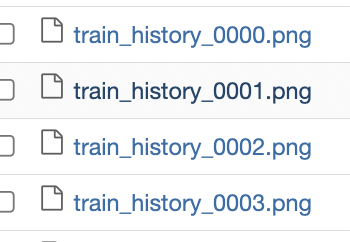

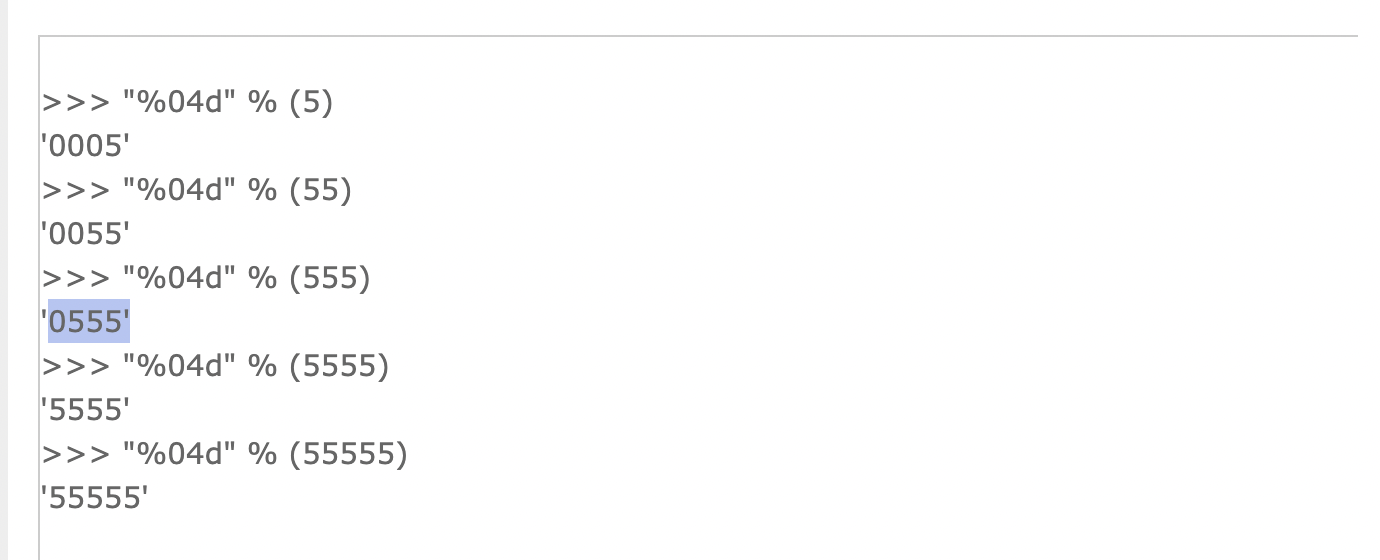

다음은 정기적으로 모델을 저장하기 위한 checkpoint를 만들어줍니다.

`tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해 주지 않아도,  
코드 한 줄로 빠르고 편하게 버전 관리를 할 수 있습니다.  
__모델이 복잡해지고 학습 속도가 오래 걸릴수록,  
모델에 대한 저장 및 버전 관리는 필수적__  
아주 오랜 시간 동안 학습을 시켰는데 네트워크가 끊긴다거나,  
예상치 못한 문제로 인해 모델을 잃어버린다면 그보다 끔찍한 일은 없을 테니까요..!

`checkpoint`에는 __optimizer와 생성자, 판별자__ 를 모두 넣어 저장합니다.  
정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것이죠.  
게임의 체크포인트처럼 우리의 학습 환경과 학습한 내용을 저장해 둡니다.

In [190]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

1. 지금까지 한 단계를 학습하는 train_step, 
2. 샘플 이미지를 생성하고 저장하기 위한 generate_and_save_images(), 
3. 학습 과정을 시각화하는 draw_train_history(), 
4. 모델까지 저장하기 위한 checkpoint까지 모두 준비가 되었으니 
5. 이것들을 한곳에 합치기만 하면 됩니다.

In [191]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [192]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

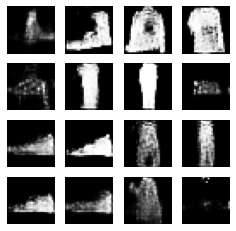

Time for training : 1238 sec


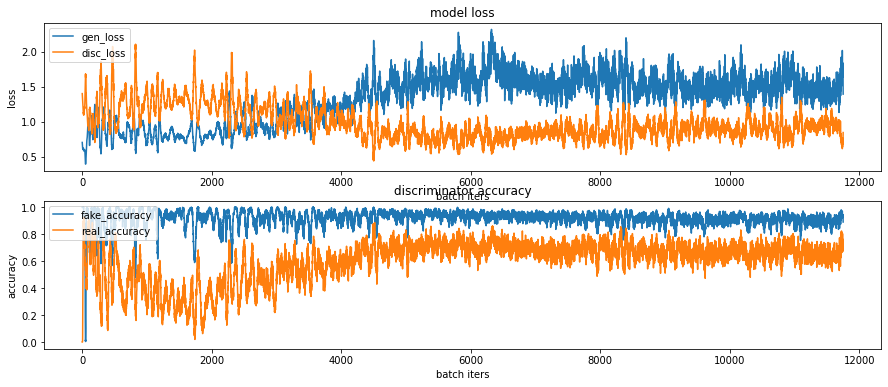

CPU times: user 8min 36s, sys: 1min 40s, total: 10min 17s
Wall time: 20min 39s


In [193]:
%%time
train(train_dataset, EPOCHS, save_every)

만약 생성자가 만든 Fake Image에 대한  
판별자의 Accuracy(fake_accuracy)가   
계속 1에 가깝게 유지되고 있다면,  
__생성자가 만든 이미지가 아직 판별자를 성공적으로 속이지 못하고 있다__ 

---
보다 나은 결과물을 만들기 위해서는 더욱 많은 epoch으로 학습을 시켜야 합니다.  
결과물이 아직 흐릿하다면 더욱 많은 학습을 시켜보세요!  

어쩌면 단순히 학습 수행 시간만 늘리는 것보다,  
모델 구조나 학습 방법을 바꾸어 봐야 할 수도 있습니다.  
그래프를 유심히 보면서   
학습 결과가 더 이상 개선되고 있지 않은지 여부를 지속적으로 살펴봅시다.  

### 학습과정 시각화하기
GIF 파일은 우리가 오래전에 import 해놓았던 imageio 라이브러리를 활용해 만들 수 있습니다.
imageio.get_writer를 활용해서 파일을 열고,  
거기에 append_data로 이미지를 하나씩 붙여나가는 방식입니다.

In [196]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1020836 Mar  2 05:34 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


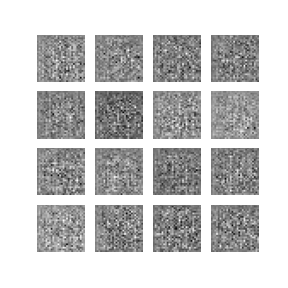